# Dreambooth fine-tuning for Stable Diffusion using d🧨ffusers 

This notebook shows how to "teach" Stable Diffusion a new concept via Dreambooth using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Dreambooth Example](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)
_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_ 

Differently from Textual Inversion, this approach trains the whole model, which can yield better results to the cost of bigger models.

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



## this notebook forked from 
https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb



In [1]:
#@title Install the required libs
# stable-diffusion-notebook-deps
!pip install --upgrade diffusers transformers scipy ftfy
!pip install flax==0.5.0 --no-deps
!pip install ipywidgets msgpack rich

# sd_dreambooth_training deps
!pip install -qq diffusers==0.4.1 accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.6/229.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 45.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.1
    Uninstalling scipy-1.8.1:
      Successfully uninstalled scipy-1.8.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.8.1
    Uninstalling huggingface-hub-0.8.1:
      Successfully uninstalled huggingface-hub-0.8.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 25.9 MB

# Log in to HuggingFace for access to models

In order to access the models from CompVis for Stable Diffusion, you must follow three steps:

1. You must acknowledge and agree to their user requirements and license for their models. you can do so by reading the instructions found on this page: https://huggingface.co/CompVis/stable-diffusion-v1-4

2. You must login to Huggingface, and then create and retrieve an access token (found here: https://huggingface.co/settings/tokens)

3. Finally, replace the segment of the cell below `<your_huggingface_token>` with your own token, and run the cell. 

If you follow these steps, you will be able to access the model for free!

In [2]:
#@title Login to the Hugging Face Hub
#@markdown Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-dreambooth-library)
# from huggingface_hub import notebook_login
# !git config --global credential.helper store

import os
from pathlib import Path
import argparse


# insert your hugging face token here
token = "<your_huggingface_token>"


def login_script():
    os.mkdir('/root/.huggingface')

    Path('/root/.huggingface/token').touch()
    with open('/root/.huggingface/token', 'w') as f:
        f.write(token)


login_script()

In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/paths.py:20: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/paths.py:98: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain libcudart.so as expected! Searching further paths...
  warn(
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/paths.py:20: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('443'), PosixPath('tcp'), PosixPath('//10.43.0.1')}
  warn(
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/paths.py:20: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(


## Settings for teaching your new concept

In [4]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [5]:
#@title Settings for your newly created concept
#@markdown `instance_prompt` is a prompt that should contain a good description of what your object or style is, together with the initializer word `sks`  
instance_prompt = "a portrait of a sks man with glasses" #@param {type:"string"}
#@markdown Check the `prior_preservation` option if you would like class of the concept (e.g.: toy, dog, painting) is guaranteed to be preserved. This increases the quality and helps with generalization at the cost of training time
prior_preservation = False #@param {type:"boolean"}
prior_preservation_class_prompt = "a portrait of a man with glasses" #@param {type:"string"}

# path to images folder
instance_data_dir = "./textual_inversion_stephen"


# where to output images
output_dir = "outputs"

# where to save the concept locally
concept_output_dir = "stephen_concept_2"


num_class_images = 12 
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt


!mkdir $output_dir

mkdir: cannot create directory ‘outputs’: File exists


#### Advanced settings for prior preservation (optional)

In [6]:
num_class_images = 12 #@param {type: "number"}
sample_batch_size = 2
#@markdown `prior_preservation_weight` determins how strong the class for prior preservation should be 
prior_loss_weight = 1 #@param {type: "number"}


#@markdown If the `prior_preservation_class_folder` is empty, images for the class will be generated with the class prompt. Otherwise, fill this folder with images of items on the same class as your concept (but not images of the concept itself)
prior_preservation_class_folder = "./class_images" #@param {type:"string"}
class_data_root=prior_preservation_class_folder

## Teach the model the new concept (fine-tuning with Dreambooth)
Execute this this sequence of cells to run the training process. The whole process may take from 15 min to 2 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [7]:
#@title Setup the Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        
        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [8]:
#@title Generate Class Images
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

In [9]:
#@title Load the Stable Diffusion model
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae",
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet",
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

In [10]:
#@title Setting up all training args
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=512,
    center_crop=True,
    instance_data_dir=instance_data_dir,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=450,
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation, 
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder, 
    class_prompt=prior_preservation_class_prompt, 
    num_class_images=num_class_images, 
    output_dir=concept_output_dir,
)

In [11]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )
    
    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    noise, noise_prior = torch.chunk(noise, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior, noise_prior, reduction="none").mean([1, 2, 3]).mean()

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)
with torch.no_grad():
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/450 [00:00<?, ?it/s]

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

Also explore the [DreamBooth Concepts Library](https://huggingface.co/sd-dreambooth-library) 

In [ ]:
#@title Set up the pipeline 
try:
    pipe
except NameError:
    pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

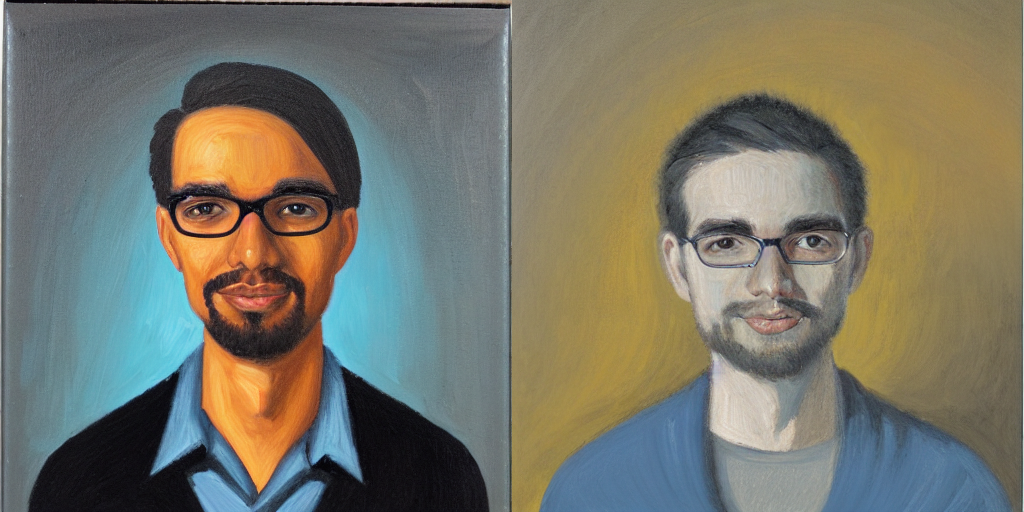

In [39]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

# reference_prompt = "a portrait of a sks man with glasses, oil on canvas" #@param {type:"string"}

prompt = "portrait of sks man with glasses, oil on canvas"

num_samples = 1 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

from time import time

t = int(time())
for i, image in enumerate(all_images):
    image.save(f"{output_dir}/dreambooth_{t}_{i}.png")
    
grid = image_grid(all_images, num_samples, num_rows)
grid